In [0]:
# Update fastai
!curl -s https://course.fast.ai/setup/colab | bash

# Link GDrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Updating fastai...
Done.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
path = Path(base_dir+'data')

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/mnist.pkl.gz'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/ml-100k.zip')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

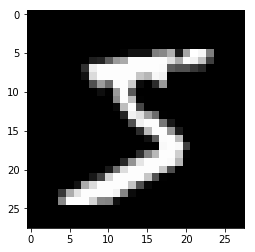

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid)) # map every numpy array to torch.tensor
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train) # grab any couple of tensors with matching dimension and create a ds from it
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) # create a DataLoader that enables automatic minibatches (from fastai)
# DataBunch.create doesn't add TOO much abstraction, just creates an iterable, shuffle data, next will grab minibatches and all the data are put on the GPU if available...

In [0]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module): # all Modules in PyTorch needs to inherit/sub_class from a nn.Module
    def __init__(self):
        super().__init__() # this is the superclass constructor, just have it in there
        self.lin = nn.Linear(784, 10, bias=True) # Linear layer is essentially x@W+b with W and b automatically initialized for you and with correct dimensions

    def forward(self, xb): return self.lin(xb)

In [0]:
# So again, we'll use the pytorch one but essentially nn.Linear is more or less 
# (with a more clever init for sure) like the one below
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=True):
    # call superclass constructor
    super(myLinear,self).__init__()

    # good practice, save the inputs
    self.in_features = in_features
    self.out_features = out_features
    self.bias=bias

    #define useful stuff
    # note that we need to tall pytorch that W and b are `nn.Parameter`s
    # this will allow the system to know that it needs compute gradients wrt to them
    self.W = nn.Parameter( 
        torch.normal(mean=0.,std=0.1,size=(self.in_features,self.out_features)))
    if self.bias:
      self.b = nn.Parameter(
          torch.normal(mean=0.,std=0.1,size=(self.out_features,)))

  # forward function, pytorch will define the backward for us
  def forward(self,xb):   
    if self.bias:
      return xb @ self.W + self.b
    return xb @ self.W


a = nn.Linear(784,10,bias=True)
b = myLinear(784,10,bias=True)

# send both models to the GPU
a.to(x.device)
b.to(x.device)

xa = a.forward(x)
xb = b.forward(x)

xa.shape, xb.shape, xa[0,:], xb[0,:]

(torch.Size([64, 10]),
 torch.Size([64, 10]),
 tensor([ 0.0092, -0.1255, -0.1434,  0.2200,  0.2405,  0.0252,  0.2426, -0.0280,
          0.0801, -0.0943], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([-0.5680,  0.9082,  0.2559, -2.1940,  0.8389, -0.2103,  1.0354,  2.2043,
         -1.4967, -1.4281], device='cuda:0', grad_fn=<SliceBackward>))

In [0]:
model = Mnist_Logistic().cuda()

In [0]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()] # we can recover W and b with model.parameters()

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss() # nn.CrossEntropyLoss will compute the softmax for you by default

In [0]:
def update(x,y,lr):
    wd = 1e-5 # weight decay
    y_hat = model(x) # this is the forward function of course
    # weight decay, L2 regularization
    L2 = 0.
    for p in model.parameters(): L2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + L2*wd

    # call the backward and (with no_grad() to deativate the autograd engine i.e. operations inside won't be differentiated)
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_() # reset the gradient, or it'll be cumulated

    return loss.item() # item is just to return a plain python 'number' rather than `torch.tensor`s

Now we can atually better see why the L2 reg. parameter is called weight decay (wd) ! Because as a whole, L2 reg. only impacts the gradient in the update function, and the gradient $\frac{ d wd \times W^2}{d W}$ is simply $2wd \times W$ and thus (forgetting the 2 without loss of generality) by subtracting this from $W$ we're simply DECAYING it toward 0 (by subtracting to it a small multiple of itself!) ... mindblown

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl] # for each minibatch extracted by the iterator in data.train_dl (DataLoader), call the update function

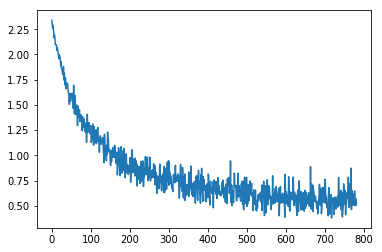

In [0]:
plt.plot(losses);

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

In [0]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda() # just to reset the weights

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr, weight_decay=1e-5) 
    #optim.SGD woudl be equivalent to what we've done above
    y_hat = model(x)
    loss = loss_func(y_hat, y) # no need to add wd here! Adam has it
    loss.backward()
    opt.step() # this substitute the parameters update and do it for us!
    opt.zero_grad() # remember to zero out gradients
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

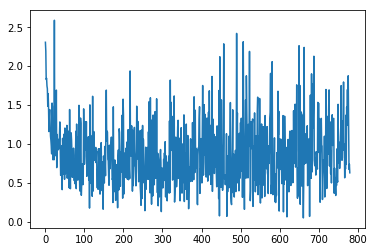

In [0]:
plt.plot(losses);

AH! It's DIVERGING! or not converging at all anyway...we're using a different optim so we need a different learning rate

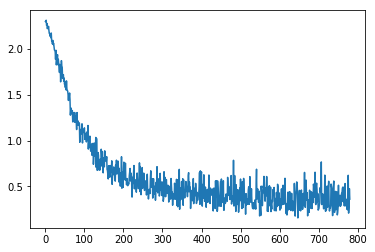

In [0]:
model = Mnist_NN().cuda() # just to reset the weights
losses = [update(x,y,5e-4) for x,y in data.train_dl]
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [0]:
%debug #just to show that I can do it

> <ipython-input-24-86338272abf3>(35)<module>()
     33 
     34 xa = a.forward(x)
---> 35 xb = b.forward()
     36 
     37 xa.shape, xb.shape, xa[0,:], xb[0,:]

ipdb> 
ipdb> 
ipdb> 
ipdb> a
ipdb> xb
tensor([[-0.5680,  0.9082,  0.2559, -2.1940,  0.8389, -0.2103,  1.0354,  2.2043,
         -1.4967, -1.4281],
        [ 0.4343,  1.1632,  1.1577, -2.2139,  0.8309,  0.6740,  1.3264, -0.2042,
         -1.1623, -0.1260],
        [ 0.3027,  0.7850,  0.9349,  0.0984, -0.5485, -0.1123,  1.6092,  1.3300,
         -1.4386,  0.0798],
        [-0.7218,  1.3149,  1.2585, -0.8141,  0.1775,  0.9890, -0.1987,  0.9751,
         -0.6687,  0.2687],
        [-0.4148,  1.2282,  2.1931, -1.3456,  0.7587,  0.0697,  0.7701,  1.5571,
         -1.1149, -0.0427],
        [ 0.0494,  1.9441,  2.3562, -0.0994,  1.0562, -0.7031,  1.3426,  1.3683,
         -1.7393, -0.7419],
        [-0.4397,  0.3089,  1.3491, -0.3975,  0.8316,  1.1154,  1.2465, -0.1308,
         -0.9646, -0.7519],
        [ 1.2090,  0.6782,  1.3135, 

In [0]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
learn.fit_one_cycle(1, 1e-2)

By the way, note how we got 96% on MNIST with just a tiny 2 layer NN ... @_@

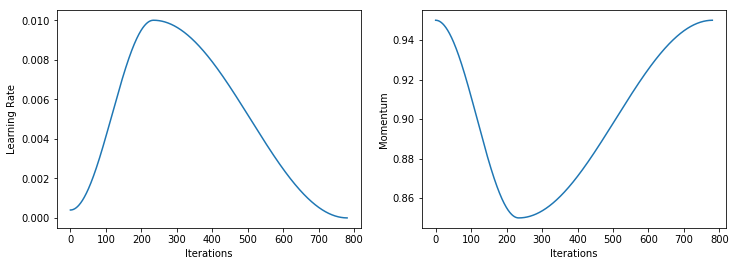

In [0]:
learn.recorder.plot_lr(show_moms=True)

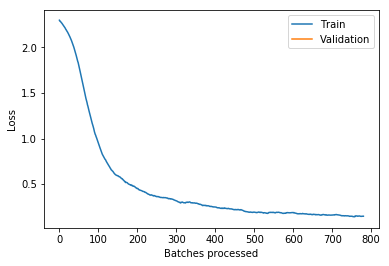

In [0]:
learn.recorder.plot_losses()

## fin